# Clustering and Classification Noteebook

### Load Feature-Engineered Dataset


In [27]:
import pandas as pd

# Load the feature-engineered dataset
df = pd.read_csv("../Data/breast_cancer_feature_engineered.csv")

print("Data loaded. Shape:", df.shape)
print(df.head())

Data loaded. Shape: (286, 27)
     age menopause tumor-size inv-nodes node-caps  deg-malig breast  \
0  40-49   premeno      15-19       0-2       yes          3  right   
1  50-59      ge40      15-19       0-2        no          1  right   
2  50-59      ge40      35-39       0-2        no          2   left   
3  40-49   premeno      35-39       0-2       yes          3  right   
4  40-49   premeno      30-34       3-5       yes          2   left   

  breast-quad irradiat                 Class  ...  node_caps_yes  irradiat_no  \
0     left_up       no     recurrence-events  ...           True         True   
1     central       no  no-recurrence-events  ...          False         True   
2    left_low       no     recurrence-events  ...          False         True   
3    left_low      yes  no-recurrence-events  ...           True        False   
4    right_up       no     recurrence-events  ...           True         True   

   irradiat_yes  breast_left  breast_right  quad_central

### Prepare Scaled Feature Matrix for Clustering


In [28]:
from sklearn.preprocessing import StandardScaler

# Drop columns not needed for clustering
columns_to_exclude = ['age', 'menopause', 'tumor-size', 'inv-nodes',
                      'node-caps', 'breast', 'breast-quad', 'irradiat', 'Class']

# Get only the engineered + one-hot features
X = df.drop(columns=columns_to_exclude)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(" Feature matrix ready. Shape:", X_scaled.shape)


 Feature matrix ready. Shape: (286, 18)


###  Determine Optimal Number of Clusters (k)


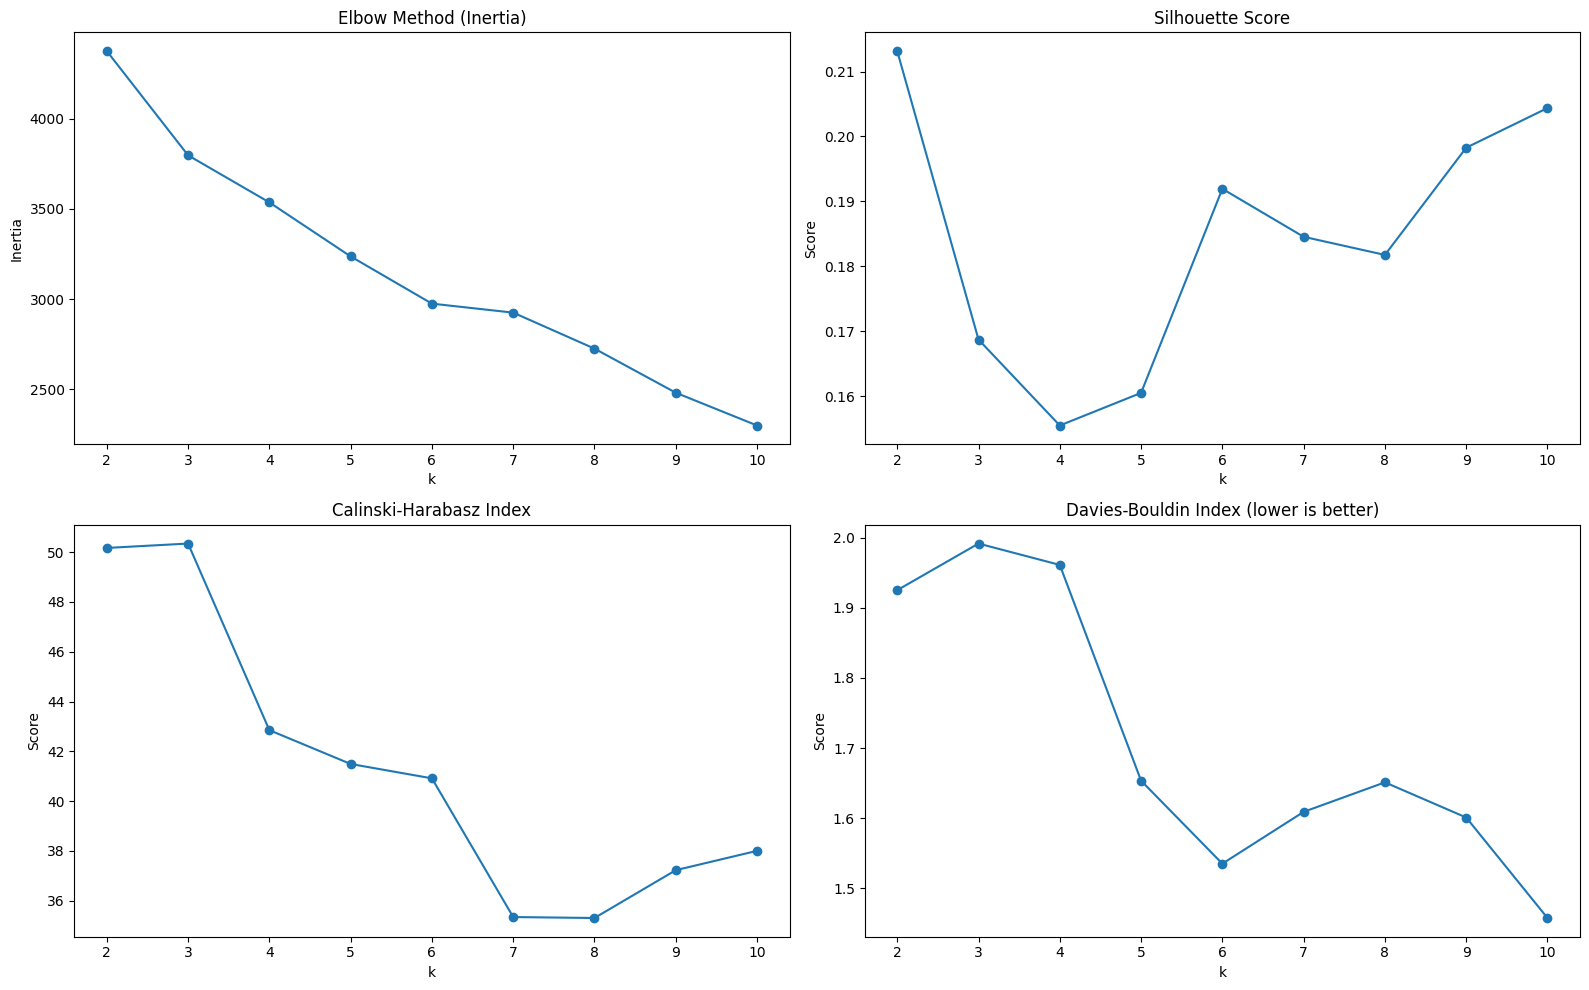

In [29]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Try different cluster counts
k_values = range(2, 11)

# To store evaluation results
inertia = []
silhouette = []
calinski = []
davies = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))
    calinski.append(calinski_harabasz_score(X_scaled, labels))
    davies.append(davies_bouldin_score(X_scaled, labels))

# Plot results
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(2, 2, 2)
plt.plot(k_values, silhouette, marker='o')
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Score")

plt.subplot(2, 2, 3)
plt.plot(k_values, calinski, marker='o')
plt.title("Calinski-Harabasz Index")
plt.xlabel("k")
plt.ylabel("Score")

plt.subplot(2, 2, 4)
plt.plot(k_values, davies, marker='o')
plt.title("Davies-Bouldin Index (lower is better)")
plt.xlabel("k")
plt.ylabel("Score")

plt.tight_layout()
plt.show()


### Chosen Number of Clusters: k = 2

The clustering evaluation metrics showed some variation in optimal `k`, with contenders being:

- **k = 2**: Highest Silhouette Score and Calinski-Harabasz Index
- **k = 3–4**: Reasonable balance between inertia drop and separation
- **k = 6–10**: Strong Davies-Bouldin Index, suggesting some deeper structure

Despite the diversity in results, I chose **k = 2** for the following reasons:
- It is a strong contender across multiple metrics
- It aligns with the original data's two-class structure (`recurrence-events` vs `no-recurrence-events`)
- It simplifies interpretation and downstream classification

This choice ensures interpretability while respecting both data patterns and domain context.

### Apply KMeans Clustering with k=2

In [30]:
from sklearn.cluster import KMeans

# Apply KMeans with k=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the original DataFrame
df['Cluster_Label'] = cluster_labels

# Preview results
print("Cluster labels assigned:")
print(df[['Cluster_Label']].value_counts())
print(df[['Cluster_Label', 'Class']].head())  # Peeking at relationship with original class labels


Cluster labels assigned:
Cluster_Label
1                226
0                 60
Name: count, dtype: int64
   Cluster_Label                 Class
0              0     recurrence-events
1              1  no-recurrence-events
2              1     recurrence-events
3              0  no-recurrence-events
4              0     recurrence-events


### 2D Cluster Visualization of Clusters Using PCA



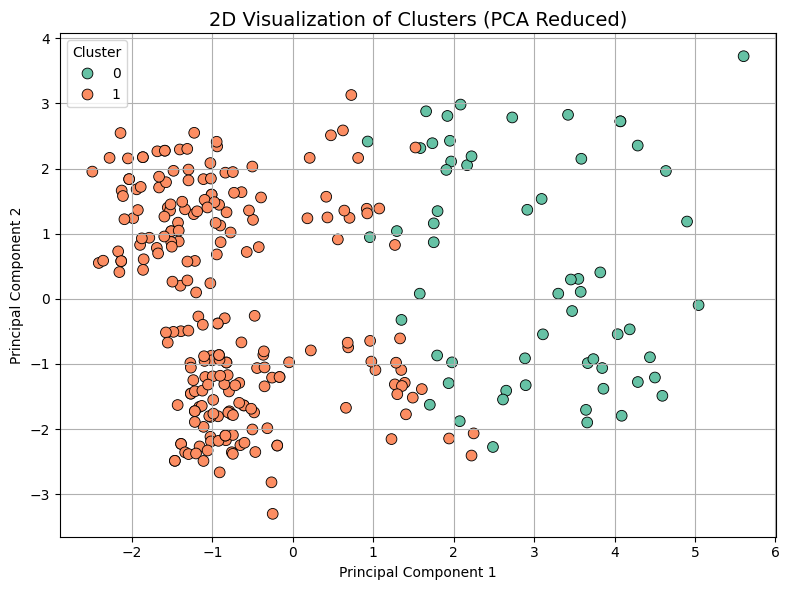

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components and cluster labels to a DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = df['Cluster_Label']

# Plot clusters in 2D space
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=60, edgecolor='k')
plt.title("2D Visualization of Clusters (PCA Reduced)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


### Evaluate Clustering Accuracy Against Original Class


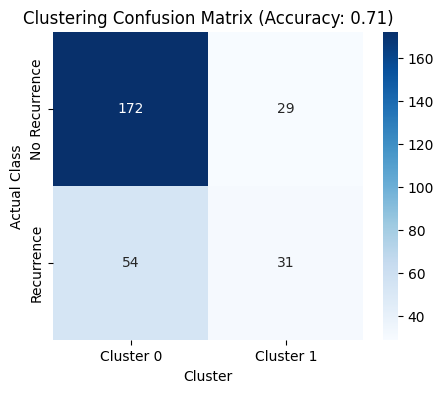

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure binary label encoding
df['Class_Encoded'] = df['Class'].map({'no-recurrence-events': 0, 'recurrence-events': 1})

# Evaluate both possible label assignments
original_acc = accuracy_score(df['Class_Encoded'], df['Cluster_Label'])
flipped_acc = accuracy_score(df['Class_Encoded'], 1 - df['Cluster_Label'])

# Use the better one
if flipped_acc > original_acc:
    cluster_eval_labels = 1 - df['Cluster_Label']
    acc = flipped_acc
    cm = confusion_matrix(df['Class_Encoded'], cluster_eval_labels)
else:
    cluster_eval_labels = df['Cluster_Label']
    acc = original_acc
    cm = confusion_matrix(df['Class_Encoded'], cluster_eval_labels)

# Confusion matrix plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1'],
            yticklabels=['No Recurrence', 'Recurrence'])
plt.xlabel("Cluster")
plt.ylabel("Actual Class")
plt.title(f"Clustering Confusion Matrix (Accuracy: {acc:.2f})")
plt.show()


### Clustering Evaluation: ROC Curve and Classification Report


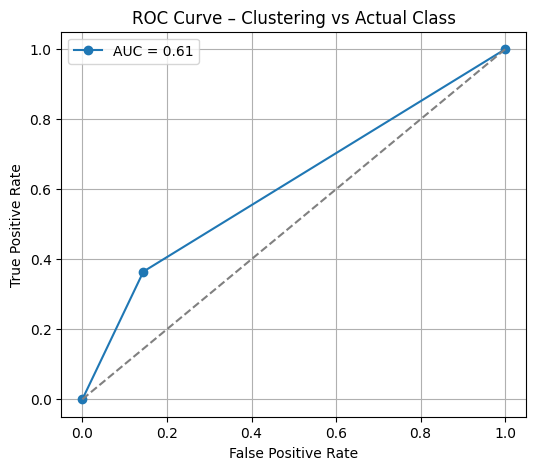

Classification Report (Clustering vs Real Class):
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       201
           1       0.52      0.36      0.43        85

    accuracy                           0.71       286
   macro avg       0.64      0.61      0.62       286
weighted avg       0.69      0.71      0.69       286



In [33]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report


# ROC AUC
roc_auc = roc_auc_score(df['Class_Encoded'], cluster_eval_labels)

# ROC Curve
fpr, tpr, thresholds = roc_curve(df['Class_Encoded'], cluster_eval_labels)

# Plot ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, marker='o', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Clustering vs Actual Class")
plt.legend()
plt.grid(True)
plt.show()

# Classification Report
print("Classification Report (Clustering vs Real Class):")
print(classification_report(df['Class_Encoded'], cluster_eval_labels))


## Classification

### Prepare Data for Classification (Cluster_Label as Target)

In [34]:
from sklearn.model_selection import train_test_split

# Drop unnecessary columns
X = df.drop(columns=['Class', 'Class_Encoded', 'Cluster_Label',
                     'age', 'menopause', 'tumor-size', 'inv-nodes',
                     'node-caps', 'breast', 'breast-quad', 'irradiat'])

y = df['Cluster_Label']  # use clusters as labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data split complete. Train shape:", X_train.shape, "| Test shape:", X_test.shape)


Data split complete. Train shape: (228, 18) | Test shape: (58, 18)


### Classification: Decision Tree

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, classification_report

# Train the model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict
y_pred = dt_model.predict(X_test)
y_prob = dt_model.predict_proba(X_test)[:, 1]

# Evaluation
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
rmse = mean_squared_error(y_test, y_prob, squared=False)

print("Decision Tree Performance:")
print(f"Accuracy: {acc:.2f}")
print(f"ROC AUC: {roc:.2f}")
print(f"RMSE: {rmse:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Decision Tree Performance:
Accuracy: 1.00
ROC AUC: 1.00
RMSE: 0.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        46

    accuracy                           1.00        58
   macro avg       1.00      1.00      1.00        58
weighted avg       1.00      1.00      1.00        58



c:\Users\Tarık Buğra Ay\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


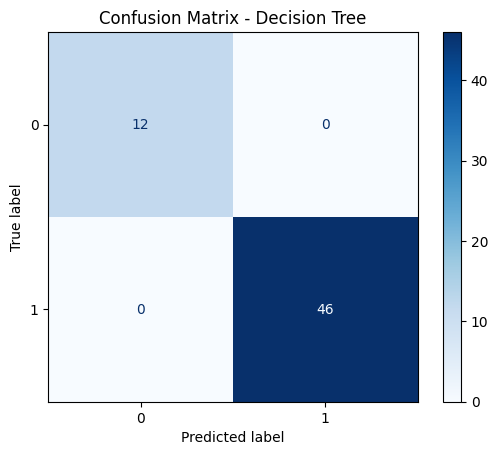

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Decision Tree")
plt.show()


### ROC Curve and Evaluation – Classifier Predicting Cluster Labels

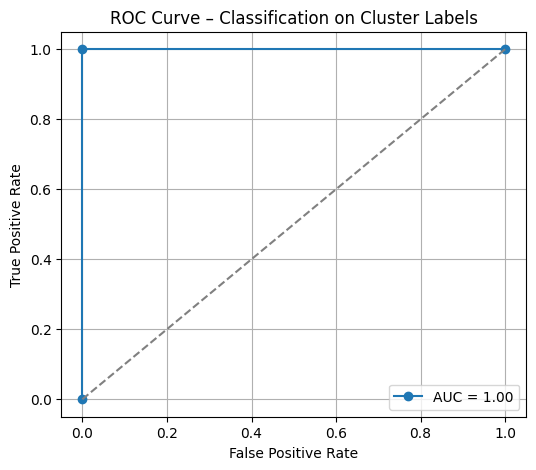

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        46

    accuracy                           1.00        58
   macro avg       1.00      1.00      1.00        58
weighted avg       1.00      1.00      1.00        58



In [37]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# Plot ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Classification on Cluster Labels")
plt.legend()
plt.grid(True)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


### Decision Tree Classifier on Cluster Labels

A Decision Tree classifier was trained using the `Cluster_Label` generated by KMeans clustering as the target.  
The model was trained on the same feature set used during clustering, and evaluated on a holdout test set.

**Evaluation Results:**
- Accuracy: 1.00
- ROC AUC: 1.00
- RMSE: 0.00

These results indicate that the model was able to predict the cluster assignments without error on the test data.
--- 

### Predicting the Actual Class Label (`recurrence-events`)

Until now, we trained classifiers to predict the `Cluster_Label` generated by KMeans. 
Now, for comparison, we will train a Decision Tree to predict the **original `Class`** column — the actual medical outcome (`recurrence-events` or `no-recurrence-events`).

This allows us to:
- Compare model performance on real labels vs synthetic clusters
- See how well our features reflect actual recurrence patterns


In [38]:
# Use same features as before
X_real = df.drop(columns=['Class', 'Class_Encoded', 'Cluster_Label', 
                          'age', 'menopause', 'tumor-size', 'inv-nodes', 
                          'node-caps', 'breast', 'breast-quad', 'irradiat'])


y_real = df['Class_Encoded']  # Actual target: 0 = no recurrence, 1 = recurrence

# Train-test split
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42, stratify=y_real
)

# Train Decision Tree
dt_real = DecisionTreeClassifier(random_state=42)
dt_real.fit(X_train_real, y_train_real)

# Predict
y_pred_real = dt_real.predict(X_test_real)
y_prob_real = dt_real.predict_proba(X_test_real)[:, 1]

# Evaluate
acc_real = accuracy_score(y_test_real, y_pred_real)
roc_real = roc_auc_score(y_test_real, y_prob_real)
rmse_real = mean_squared_error(y_test_real, y_prob_real, squared=False)

print("Decision Tree on Real Class Labels:")
print(f"Accuracy: {acc_real:.2f}")
print(f"ROC AUC: {roc_real:.2f}")
print(f"RMSE: {rmse_real:.2f}")
print("\nClassification Report:")
print(classification_report(y_test_real, y_pred_real))

Decision Tree on Real Class Labels:
Accuracy: 0.71
ROC AUC: 0.64
RMSE: 0.53

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        41
           1       0.50      0.41      0.45        17

    accuracy                           0.71        58
   macro avg       0.64      0.62      0.63        58
weighted avg       0.69      0.71      0.70        58



c:\Users\Tarık Buğra Ay\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


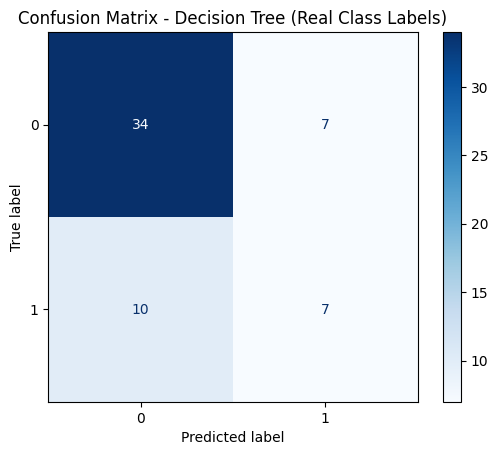

In [39]:
# Plot confusion matrix for the real label classification
cm_real = confusion_matrix(y_test_real, y_pred_real)
disp_real = ConfusionMatrixDisplay(confusion_matrix=cm_real, display_labels=dt_real.classes_)
disp_real.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Decision Tree (Real Class Labels)")
plt.show()

### ROC Curve and Evaluation – Classifier Predicting Real Class Labels


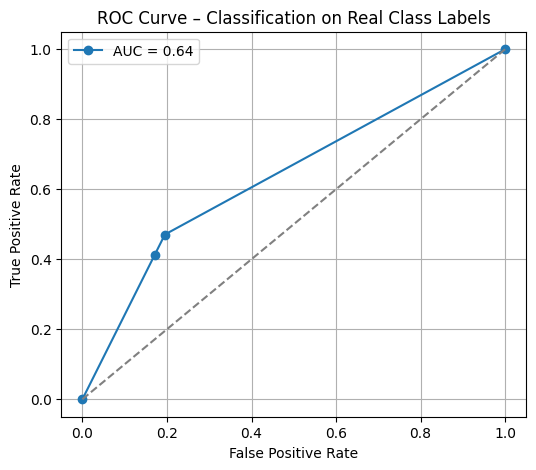

Classification Report (Real Class Labels):
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        41
           1       0.50      0.41      0.45        17

    accuracy                           0.71        58
   macro avg       0.64      0.62      0.63        58
weighted avg       0.69      0.71      0.70        58



In [17]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# ROC Curve and AUC for real class prediction
fpr_real, tpr_real, thresholds_real = roc_curve(y_test_real, y_prob_real)
auc_real = roc_auc_score(y_test_real, y_prob_real)

# Plot ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr_real, tpr_real, label=f"AUC = {auc_real:.2f}", marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Classification on Real Class Labels")
plt.legend()
plt.grid(True)
plt.show()

# Print classification report
print("Classification Report (Real Class Labels):")
print(classification_report(y_test_real, y_pred_real))


### Comparison: Predicting Cluster Labels vs. Actual Class Labels

Two separate Decision Tree models were trained and evaluated:

1. **Cluster-Based Model**  
   - Target: `Cluster_Label` (generated by KMeans)  
   - Accuracy: 1.00  
   - ROC AUC: 1.00  
   - RMSE: 0.00  

2. **Real Class-Based Model**  
   - Target: `Class` (`recurrence-events` vs `no-recurrence-events`)  
   - Accuracy: 0.71  
   - ROC AUC: 0.64  
   - RMSE: 0.53  

The cluster-based model used the same feature set that was involved in generating the clusters via KMeans.  
The class-based model was trained to predict the actual recurrence outcomes using the same features.

Differences in results reflect the difference in the nature of the target variables.
